## Estimating envelope functions

Core idea is the "isotropy principle": the marginal distributions of any $\theta$ should be the same at any chosen pitch period. But *joint* draws of $p(\theta|\alpha)$ are heavily correlated by the envelope correlation kernel $k(i,j)$ learned from real data. We assume source and filter have different envelope kernels.

Note 1: for the pitch period envelope, we can make definite predictions about jitter and shimmer values.

### Envelope learning from Praat estimates

In principle we work with fixed hyperparameters $\hat \alpha$, and predict $p(\theta|\hat\theta,\hat\alpha)$ using a conditioned Gaussian process. In other words, we do not adjust the envelope $\lambda$ or Praat estimation noise $\delta^2$ based on Praat's estimate for the data at hand.

But we could also learn the envelope from $\hat\theta$ by doing MAP over $\alpha$ starting from $\hat\alpha$ or even using nested sampling using $p(\alpha|D)$ as a prior for $\alpha$, where $D$ is the relevant TIMIT dataset. In other words, we learn the envelope parameters $\alpha$ from TIMIT and can represent this information either as a delta prior $p(\alpha|D) = \delta(\alpha-\hat\alpha)$, or retain the uncertainty, e.g. as a Gaussian $p(\alpha|D) = N(\alpha;\hat\alpha,\sigma_\alpha^2)$.

In [1]:
%run init.ipy
import pandas as pd

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

## Formants

In [2]:
from lib import htkio

formant_data, frate, feakind = htkio.htkread("dgf/test/si1149.fb")

formants = formant_data[:3,:].T

formants # kHz

array([[0.60038465, 1.54463804, 2.50881076],
       [0.64932722, 1.5456332 , 2.52436972],
       [0.66138232, 1.47878063, 2.59593034],
       ...,
       [0.62746179, 1.38237345, 2.71759462],
       [0.54841679, 1.44805717, 2.46356225],
       [0.57549101, 1.45660532, 2.39775181]])

GP_regression.,value,constraints,priors
rbf.variance,0.1834167233878824,+ve,
rbf.lengthscale,4.745121705315349,+ve,
Gaussian_noise.variance,0.00029640013967929086,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f46db1b0940>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f46db1b0f40>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f46db1b0820>]}

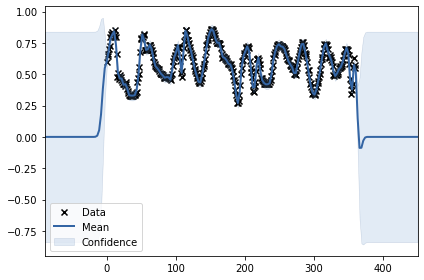

In [3]:
import GPy

X = np.arange(formants.shape[0])[:,None]
Y = formants[:,0][:,None]

kernel = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X,Y,kernel)
model.optimize(messages=True)
display(model)
model.plot()

### Prior mean and coveriances for the VTR frequencies

Estimation of prior mean and covariances for the VTR frequencies in the latent log space. Notes:
- The latent MVN in log space is highly correlated and encodes approximately the ordering of the VTRs;
- This correlation should be taken into account.
- The latent MVN in log space underestimates the fat tails of the true distribution of `p(log x)` (which looks similar to a Landau distribution). Thus the VTR frequencies tend to be shy of higher frequencies (say > 2000 Hz). I don't think this will be a problem, as there is still mass at these higher frequencies, but if this turns out to be one, we could apply a FITC-like diagonal correction to the covariance matrix.
- We don't use the pdf weights in estimating the mean and covariance matrices because the correct pdfs of the *truncated* distribution `sample_truncated()` require to evaluate an integral that I don't have time to evaluate
- **Units.** Our log log transformation is not fully kosher because we are log transforming quantities which are not dimensionless. It is indeed possible to do this more properly by log transforming ratios of successive VTR frequencies, as in the Pareto chain prior, but then we cannot guarantee anymore the "isotropy principle", i.e., that the marginal means and variances are constant and do not depend on the particular pitch period chosen. I've also seen MacKay do this, so it's not too bad.

array([-1.53087735, -1.0811523 , -0.76899666, -0.53017191])

array([[0.45194342, 0.42735842, 0.41609664, 0.40950608],
       [0.42735842, 0.58957719, 0.57501806, 0.56661359],
       [0.41609664, 0.57501806, 0.65498802, 0.64579145],
       [0.40950608, 0.56661359, 0.64579145, 0.69277418]])

DeviceArray([0.6400888 , 0.94591714, 1.61904607, 2.00425119], dtype=float64)

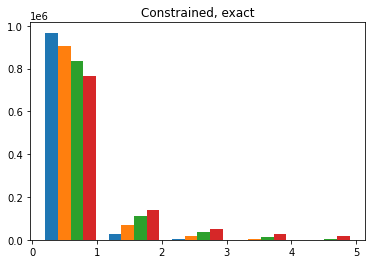

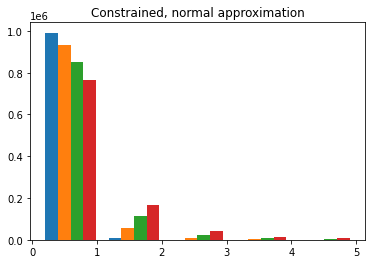

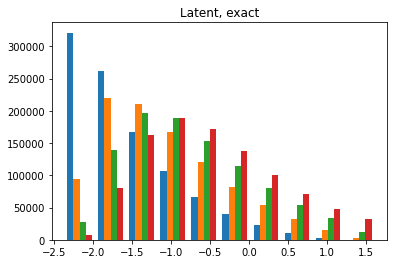

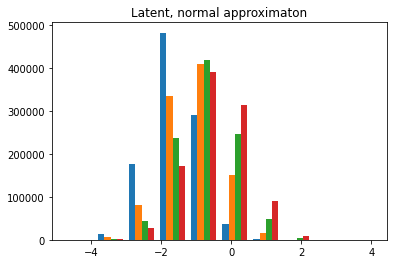

In [6]:
from vtr import sample as paretochain
from dynesty import utils as dyfunc
from dgf.bijectors import bounded_exp_bijector

def getx(nx, x0, fs, size=1):
    xmax = fs/2
    xbar = x0 + (xmax - x0)/(nx+1)*np.arange(1, nx+1)
    #xbar = 500*np.arange(1, nx+1)
    x = paretochain.sample_truncated(x0, xbar, xmax, size=size)
    return x

size = int(1e6)
npoles = 4
x0 = 100/1000
fs = 10000/1000

x = getx(npoles, x0, fs, size)
b = bounded_exp_bijector(x0, fs/2, hinge_factor=0.01)
y = asarray(b.inverse(x)) # Latent

mean, cov = dyfunc.mean_and_cov(y, ones(size)/size)
display(mean, cov) # Strongly correlated

ya = multivariate_normal(mean, cov, size=size)
xa = b.forward(multivariate_normal(mean, cov, size=size))

figure()
title("Constrained, exact")
hist(x, bins=5);

figure()
title("Constrained, normal approximation");
hist(asarray(xa), bins=5);

figure()
title("Latent, exact")
hist(y);

figure()
title("Latent, normal approximaton")
hist(ya);

# Sample from the normal approximation
xa[randint(size),:]

### VTR frequency trajectories

The covariance function $k([r,i],[s,j]) = k(r,s) k(i,j)$ has Kronecker structure. $k(r,s)$ is the covariance between VTR with indices $r$ and $s$. $k(i,j)$ is the *correlation* (i.e., has unit marginal variance) envelope.

In [14]:
mean, cov

(array([-1.53087735, -1.0811523 , -0.76899666, -0.53017191]),
 array([[0.45194342, 0.42735842, 0.41609664, 0.40950608],
        [0.42735842, 0.58957719, 0.57501806, 0.56661359],
        [0.41609664, 0.57501806, 0.65498802, 0.64579145],
        [0.40950608, 0.56661359, 0.64579145, 0.69277418]]))

In [25]:
num_pitch_periods = 100
I = jnp.arange(num_pitch_periods)

envelope_lengthscale = 7.
K_envelope = exp(-(I[:,None] - I[None,:])**2/(2*envelope_lengthscale**2))

K_full = jnp.kron(cov, K_envelope)
mean_full = jnp.kron(mean, jnp.ones(num_pitch_periods))

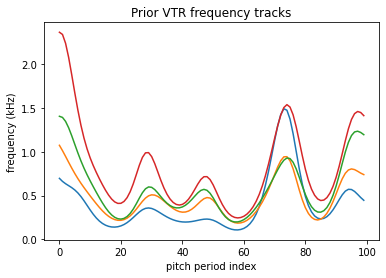

In [27]:
latent_trajectories = multivariate_normal(mean_full, K_full).reshape(npoles, num_pitch_periods)

plot(b.forward(latent_trajectories).T)
title('Prior VTR frequency tracks')
xlabel('pitch period index')
ylabel('frequency (kHz)');

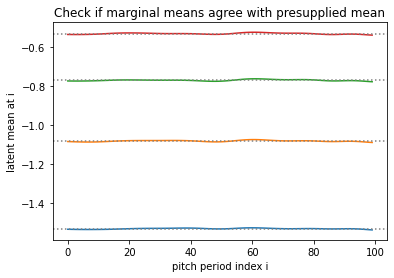

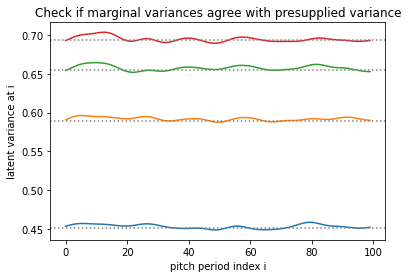

In [28]:
a = multivariate_normal(mean_full, K_full, size=50000).reshape(-1, npoles, num_pitch_periods)
plot(np.mean(a, axis=0).T)
for mi in mean: axhline(mi, ls=':', color='grey')
title('Check if marginal means agree with presupplied mean')
xlabel('pitch period index i')
ylabel('latent mean at i')

figure()
plot(np.var(a, axis=0).T)
for vi in diag(cov): axhline(vi, ls=':', color='grey')
title('Check if marginal variances agree with presupplied variance')
xlabel('pitch period index i')
ylabel('latent variance at i');

## Convolve with LF

In [30]:
from dgf.prior import lf
from dgf import isokernels
from lib import lfmodel

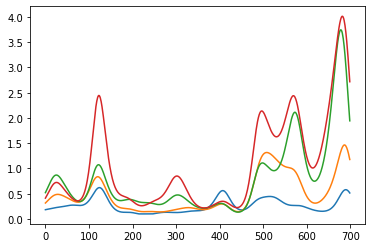

In [32]:
num_pitch_periods = 700
I = jnp.arange(num_pitch_periods)[:,None]

envelope_kernel_name = 'SqExponentialKernel'
envelope_lengthscale = 30.
K_envelope = isokernels.resolve(envelope_kernel_name)(1., envelope_lengthscale).matrix(I,I)

K_full = jnp.kron(cov, K_envelope)
mean_full = jnp.kron(mean, jnp.ones(num_pitch_periods))

latent_trajectories = multivariate_normal(mean_full, K_full).reshape(npoles, num_pitch_periods)
x = b.forward(latent_trajectories).T
plot(x)

In [33]:
import scipy.stats

logprob_z = scipy.stats.multivariate_normal(mean_full, K_full + (1e-6)*np.eye(K_full.shape[0])).logpdf(latent_trajectories.reshape(mean_full.shape))

[Memory]1475.5s, 24.6min: Loading sample_lf_params...


 /home/marnix/WRK/thesis/py/dgf/bijectors.py:69: UserWarning:The log det Jacobian of `lf_generic_params_bijector()` can become unstable for the `lf_generic_params_trajectory_prior()` because the generic LF parameters will at some point hit their bounds.


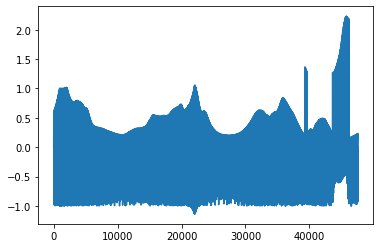

In [36]:
envelope_kernel_name = 'Matern52Kernel'
envelope_lengthscale = 30

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

sample, logprob_sample = prior.experimental_sample_and_log_prob(seed=jax.random.PRNGKey(randint(1000)))

p = lf.generic_params_to_dict(sample)
p = lfmodel.convert_lf_params(p, 'generic -> T')

GOI = jnp.cumsum(p['T0']) - p['T0'][0]
end = GOI[-1] + p['T0'][-1]
t = np.linspace(0, end, int(end*fs))

def warn_if_nans(u):
    mask = jnp.any(jnp.isnan(u), axis=1)
    if jnp.sum(mask) > 0:
        pitch_period_indices = jnp.where(mask)[0]
        import warnings
        warnings.warn(
            'Inconsistent LF parameters detected at the following pitch '
            f'period indices: {pitch_period_indices}'
        )

u = jax.vmap(jax.jit(lfmodel.dgf), in_axes=[None, 0, 0])(t, p, GOI)
warn_if_nans(u)
plot(jnp.nansum(u, axis=0))

In [14]:
from lib import klatt
klatt.play(t, jnp.nansum(u, axis=0))

In [15]:
import scipy.signal
from dgf import core

from dgf.prior import source

def support(t, T0, offset=0., pre=0, post=1):
    i = source._nonzero_dgf_indices(t - offset, T0)
    a = max(i[0] - len(i)*pre, 0)
    b = min(i[0] + len(i)*(1+post), len(t))
    return a, b

def convolve(i, u_prime, x):
    """This can be made JAX-compatible with `jax.scipy.linalg.expm()`, as `lsim()` uses `expm()`"""
    # For a real speedup maybe use `scipy.signal.cont2discrete()` and then just `jax.convolve`
    
    a, b = support(t, p['T0'][i], offset=GOI[i], pre=0, post=10) # You need 10 if you really want to capture everything
    
    # Formant bandwidths
    # followed the relation bandwidth = 80 + 120*frequency/5000 (Mehta & Wolfe 2015)
    # Better relation: Hawks (1995)
    freqs = x*1000
    bandwidths = 80 + 120*freqs/5000
    q = core.make_poles(bandwidths, freqs)

    zeros = np.array([])
    poles = np.hstack([q, np.conj(q)])
    gain = np.prod(np.abs(q)**2)

    T, y, _ = scipy.signal.lsim((zeros, poles, gain), u_prime[a:b], t[a:b])
    out = np.zeros_like(u_prime)
    out[a:b] = y
    return out

In [16]:
conv = np.array([convolve(i, ui, xi) for i, (xi, ui) in enumerate(zip(x, u))])
out = np.nansum(conv, axis=0)

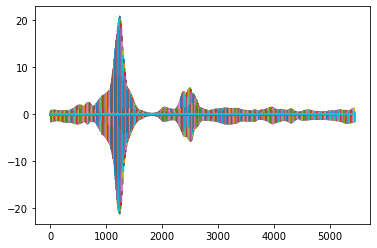

In [17]:
plot(t, conv.T);

Text(0.5, 1.0, 'log p(waveform) = 32880.069534503295')

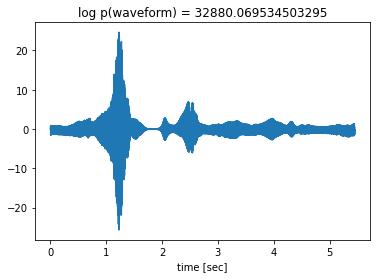

In [18]:
plot(t/1000, out)
xlabel("time [sec]")
title(f'log p(waveform) = {logprob_z + logprob_sample}')

In [19]:
klatt.play(t, out)

Measure freq and bandwidths trajectories from Praat, then sample from the trajectories conditioned on them. 